In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8-pastel')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

import os
from glob import glob  # Pattern matching file path
from PIL import Image
import itertools
np.random.seed(123)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator # For data augmentation
from tensorflow.keras.utils import plot_model    # To visualize the model architecture
from tensorflow.keras.callbacks import EarlyStopping

In [1]:
# Base directories for the two folders
base_skin_dir_1 = '/Users/liteshperumalla/Desktop/Files/Machine Learning Project/archive/HAM10000_images_part_1'
base_skin_dir_2 = '/Users/liteshperumalla/Desktop/Files/Machine Learning Project/archive/HAM10000_images_part_2'

# Merging images from both folders into one dictionary
imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join(base_skin_dir_1, '*.jpg')) + glob(os.path.join(base_skin_dir_2, '*.jpg'))
}

# This dictionary is use ful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [2]:
# Load the CSV file directly without os.path.join for the absolute path
skin_df = pd.read_csv('/Users/liteshperumalla/Desktop/Files/Machine Learning Project/archive/HAM10000_metadata.csv')

# Creating new columns for better readability
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

# Display the first 3 rows to check if everything looks good
skin_df.head(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,2


In [3]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [4]:
skin_df['age'] = skin_df['age'].fillna(skin_df['age'].mean())

In [5]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


Text(0, 0.5, 'Count')

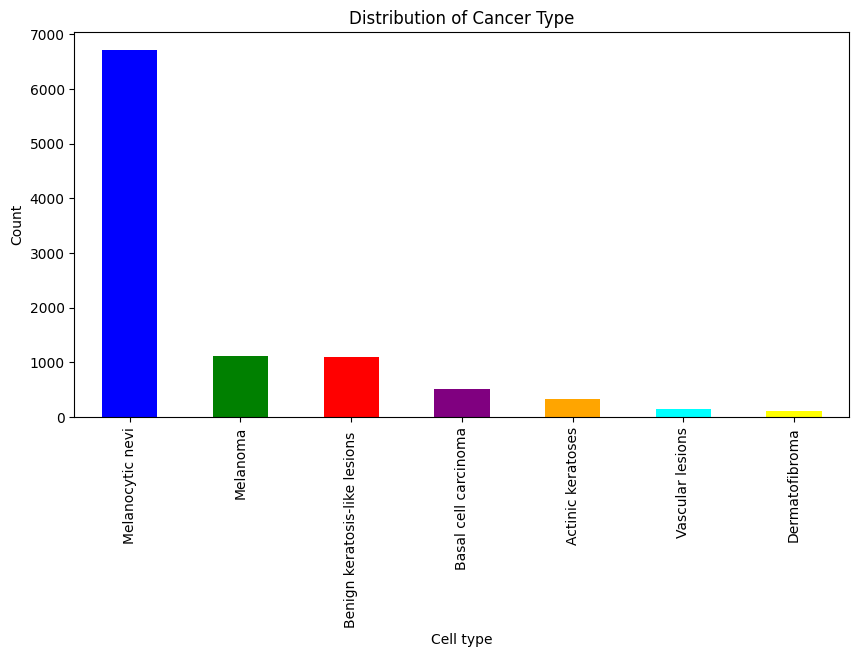

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'yellow']
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1, color=colors)
plt.title('Distribution of Cancer Type')
plt.xlabel('Cell type')
plt.ylabel('Count')

Text(0.5, 1.0, 'The type of medical diagnostics performed')

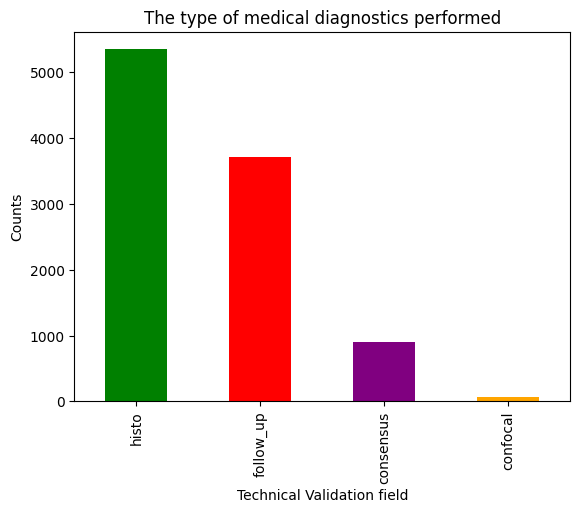

In [7]:
colors = ['green', 'red', 'purple', 'orange', 'cyan', 'yellow']
skin_df['dx_type'].value_counts().plot(kind='bar', color=colors)
plt.xlabel('Technical Validation field')
plt.ylabel('Counts')
plt.title('The type of medical diagnostics performed')


Text(0.5, 1.0, 'The body parts most susceptible for skin cancer')

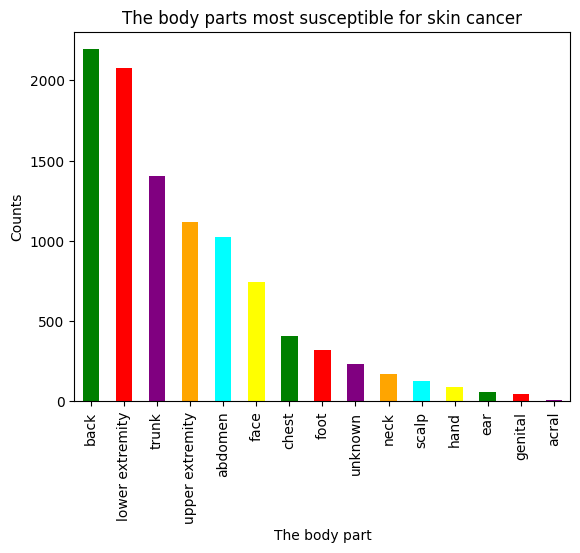

In [8]:
colors = ['green', 'red', 'purple', 'orange', 'cyan', 'yellow']
skin_df['localization'].value_counts().plot(kind='bar', color=colors)
plt.xlabel('The body part')
plt.ylabel('Counts')
plt.title('The body parts most susceptible for skin cancer')

Text(0.5, 1.0, 'Age Distribution')

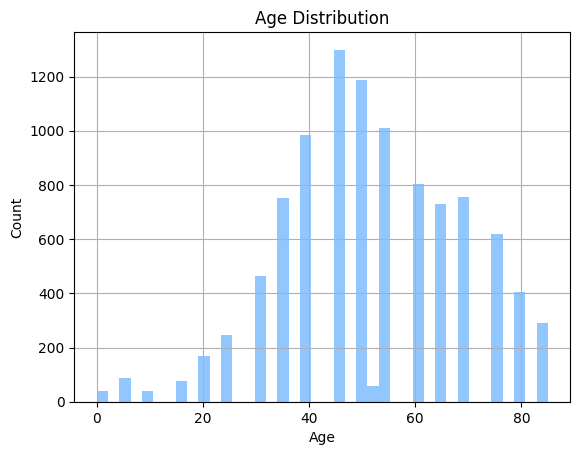

In [9]:
skin_df['age'].hist(bins=40)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')

Text(0.5, 1.0, 'Gender Distribution')

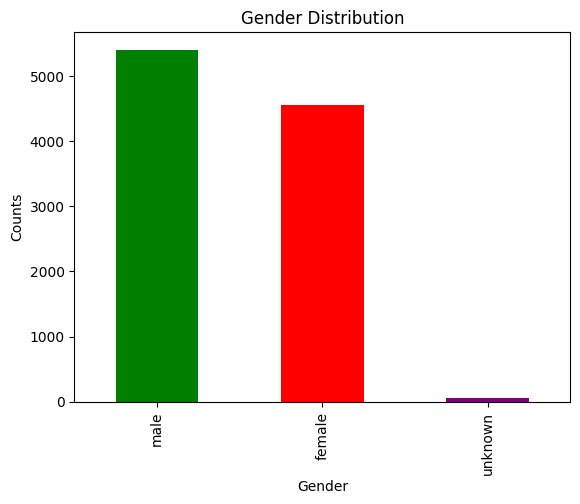

In [10]:
skin_df['sex'].value_counts().plot(kind='bar', color=colors)
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('Gender Distribution')

<Axes: xlabel='age', ylabel='cell_type_idx'>

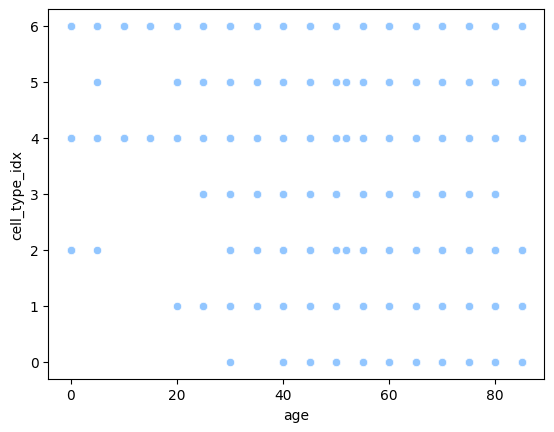

In [11]:
sns.scatterplot(data=skin_df, x= 'age',y='cell_type_idx')

<Axes: xlabel='cell_type_idx', ylabel='Density'>

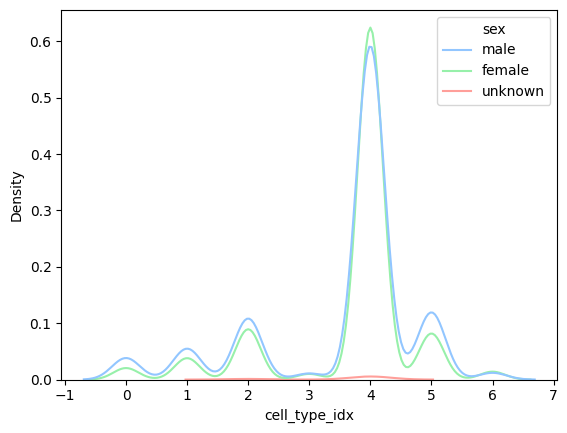

In [12]:
sns.kdeplot(data=skin_df, x='cell_type_idx', hue='sex')

In [13]:
# Function to load and resize images
def load_and_resize_image(path):
    image = tf.io.read_file(path)  # Read the image from the path
    image = tf.image.decode_jpeg(image, channels=3)  # Decode the image
    image = tf.image.resize(image, [75, 100])  # Resize the image
    return image

# Create a TensorFlow Dataset from image paths
image_paths = skin_df['path'].values

# Create a tf.data.Dataset for efficient image loading and processing
image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
image_dataset = image_dataset.map(lambda x: load_and_resize_image(x), num_parallel_calls=tf.data.AUTOTUNE)
image_dataset = image_dataset.batch(32)  # Load images in batches
image_dataset = image_dataset.prefetch(tf.data.AUTOTUNE)  # Optimize performance

# Now image_dataset is ready to be used for model training or any further processing

In [14]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [15]:
skin_df['image'] = skin_df['path'].map(lambda x: load_and_resize_image(x))

In [16]:
skin_df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,2,"(((tf.Tensor(189.75, shape=(), dtype=float32),..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,2,"(((tf.Tensor(23.75, shape=(), dtype=float32), ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,2,"(((tf.Tensor(185.25, shape=(), dtype=float32),..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,2,"(((tf.Tensor(22.5, shape=(), dtype=float32), t..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,2,"(((tf.Tensor(131.75, shape=(), dtype=float32),..."


In [17]:
skin_df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    10015
Name: count, dtype: int64

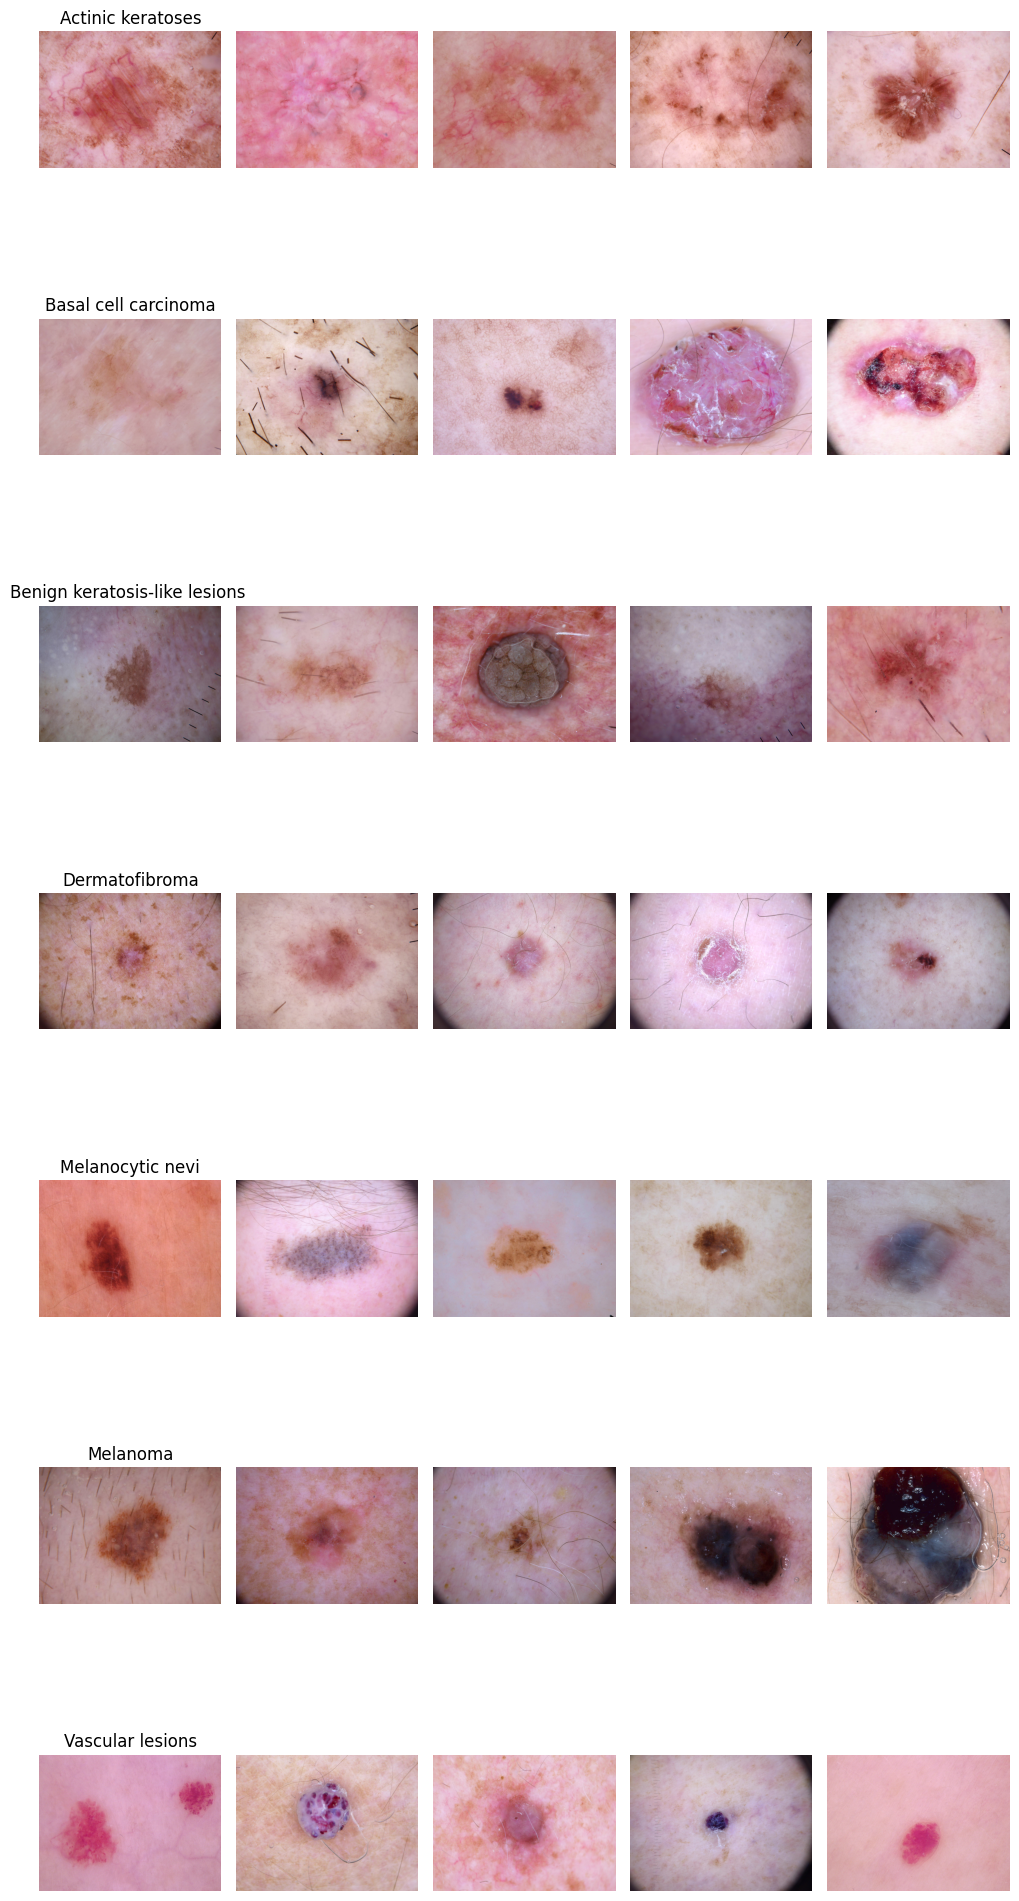

In [18]:
n_samples = 5

# Create a figure with subplots
fig, m_axs = plt.subplots(7, n_samples, figsize=(2 * n_samples, 3 * 7))

# Loop through each skin lesion type and its respective rows
for n_axs, (type_name, type_rows) in zip(m_axs, skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)  # Set the title for each row of subplots
    
    # Loop through the samples and display them
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        # Load the image from the file path and convert it to a NumPy array
        image = Image.open(c_row['path'])
        image_array = np.array(image)
        
        # Display the image
        c_ax.imshow(image_array.astype('uint8'))
        c_ax.axis('off')  # Hide the axis for cleaner display

# Save the figure or display it
fig.savefig('category_samples.png', dpi=300)
plt.tight_layout()
plt.show()

In [19]:
features = skin_df.drop(columns=['cell_type_idx'],axis=1)
target = skin_df['cell_type_idx']

In [20]:
features.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,"(((tf.Tensor(189.75, shape=(), dtype=float32),..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,"(((tf.Tensor(23.75, shape=(), dtype=float32), ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,"(((tf.Tensor(185.25, shape=(), dtype=float32),..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,"(((tf.Tensor(22.5, shape=(), dtype=float32), t..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,"(((tf.Tensor(131.75, shape=(), dtype=float32),..."


In [21]:
target.value_counts()

cell_type_idx
4    6705
5    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64

In [22]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=42)

In [23]:
x_train_o.shape

(8012, 10)

In [24]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_test_mean = np.mean(x_test)

x_train_std = np.std(x_train)
x_test_std = np.std(x_test)

X_train = (x_train - x_train_mean) / x_train_std
X_test = (x_test - x_test_mean) / x_test_std

In [25]:
X_train.shape

(8012, 75, 100, 3)

In [25]:
# Assuming y_train_o is your integer encoded labels
y_train = to_categorical(y_train_o, num_classes=7)
y_test = to_categorical(y_test_o, num_classes=7)

In [26]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
X_train.shape

(7210, 75, 100, 3)

In [35]:
from tensorflow.keras.regularizers import l2
def first_cnn_model(input_shape = (75, 100, 3), n_classes = 7):
    
    model = Sequential()
    
    #-----------------------------------------------------
    # Conv Block 1: 32 filter, 32 filter, MaxPool, Dropout
    #-----------------------------------------------------
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    #-----------------------------------------------------
    # Conv Block 2: 64 filter, 64 filter, MaxPool, Dropout
    #-----------------------------------------------------
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.40))
    
    #-----------------------------------------------------
    # Conv Block 3: 64 filter, 64 filter, MaxPool, Dropout
    #-----------------------------------------------------
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.40))
    #-----------------------------------------------------
    # Additional Conv Block: 128 filter, MaxPool
    #-----------------------------------------------------
    model.add(Conv2D(128, (3, 3), activation='relu'))   # Add new 128 filter Conv layer
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    #----------------------------------------------------
    # Fully connected layer
    #----------------------------------------------------
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.40))
    model.add(Dense(n_classes, activation='softmax'))
    
    return model

In [36]:
model = first_cnn_model(input_shape=(75, 100, 3), n_classes=7)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 75, 100, 32)       896       
                                                                 
 conv2d_15 (Conv2D)          (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 37, 50, 32)        0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 37, 50, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 37, 50, 64)        18496     
                                                                 
 conv2d_17 (Conv2D)          (None, 37, 50, 64)        36928     
                                                      

In [45]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Batch size and epochs
batch_size = 32
epochs = 100

# Resizing images during augmentation to save memory
datagen = ImageDataGenerator(
    rotation_range=20,         # Augmentation: random rotations
    width_shift_range=0.2,     # Horizontal shift
    height_shift_range=0.2,    # Vertical shift
    shear_range=0.2,           # Shear transformations
    zoom_range=0.2,            # Random zoom
    horizontal_flip=True,      # Random horizontal flips
    fill_mode='nearest'        # Fill pixels outside the input boundaries
)
datagen.fit(X_train)

# Training and validation generators with resizing on-the-fly
train_generator = datagen.flow(
    tf.image.resize(X_train, (75, 100)), y_train, batch_size=batch_size
)

# Callbacks to save the best model and stop early if needed
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=10,           # Stop if no improvement after 10 epochs
    restore_best_weights=True  # Restore the best model after stopping
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',       # Filepath to save the best model
    monitor='val_loss',    # Monitor validation loss
    save_best_only=True    # Save only the best model
)

# Model training with early stopping and checkpointing
history = model.fit(
    train_generator,                                 # Augmented and resized training data
    epochs=epochs,                                   # Number of epochs
    validation_data=(tf.image.resize(X_val, (75, 100)), y_val),  # Resized validation data
    steps_per_epoch=len(X_train) // batch_size,      # Steps per epoch
    callbacks=[early_stopping, model_checkpoint],    # Early stopping and checkpoint callbacks
    verbose=1                                        # Show progress during training
)

Epoch 1/100
225/225 [==============================] - 134s 595ms/step - loss: 5.1726 - accuracy: 0.6542 - val_loss: 1.1258 - val_accuracy: 0.6596
Epoch 2/100


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 [==============================] - 135s 599ms/step - loss: 1.0450 - accuracy: 0.6687 - val_loss: 1.0469 - val_accuracy: 0.6596
Epoch 3/100
225/225 [==============================] - 553s 2s/step - loss: 0.9759 - accuracy: 0.6716 - val_loss: 0.9929 - val_accuracy: 0.6658
Epoch 4/100
225/225 [==============================] - 445s 2s/step - loss: 0.9366 - accuracy: 0.6741 - val_loss: 1.0030 - val_accuracy: 0.6808
Epoch 5/100
225/225 [==============================] - 131s 581ms/step - loss: 0.9301 - accuracy: 0.6822 - val_loss: 0.9776 - val_accuracy: 0.6958
Epoch 6/100
225/225 [==============================] - 134s 596ms/step - loss: 0.9028 - accuracy: 0.6815 - val_loss: 0.9108 - val_accuracy: 0.6858
Epoch 7/100
225/225 [==============================] - 135s 599ms/step - loss: 0.8813 - accuracy: 0.6886 - val_loss: 0.9709 - val_accuracy: 0.6758
Epoch 8/100
225/225 [==============================] - 136s 602ms/step - loss: 0.8859 - accuracy: 0.6956 - val_loss: 0.9789 - val_accura

In [55]:
%pip install pydot
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


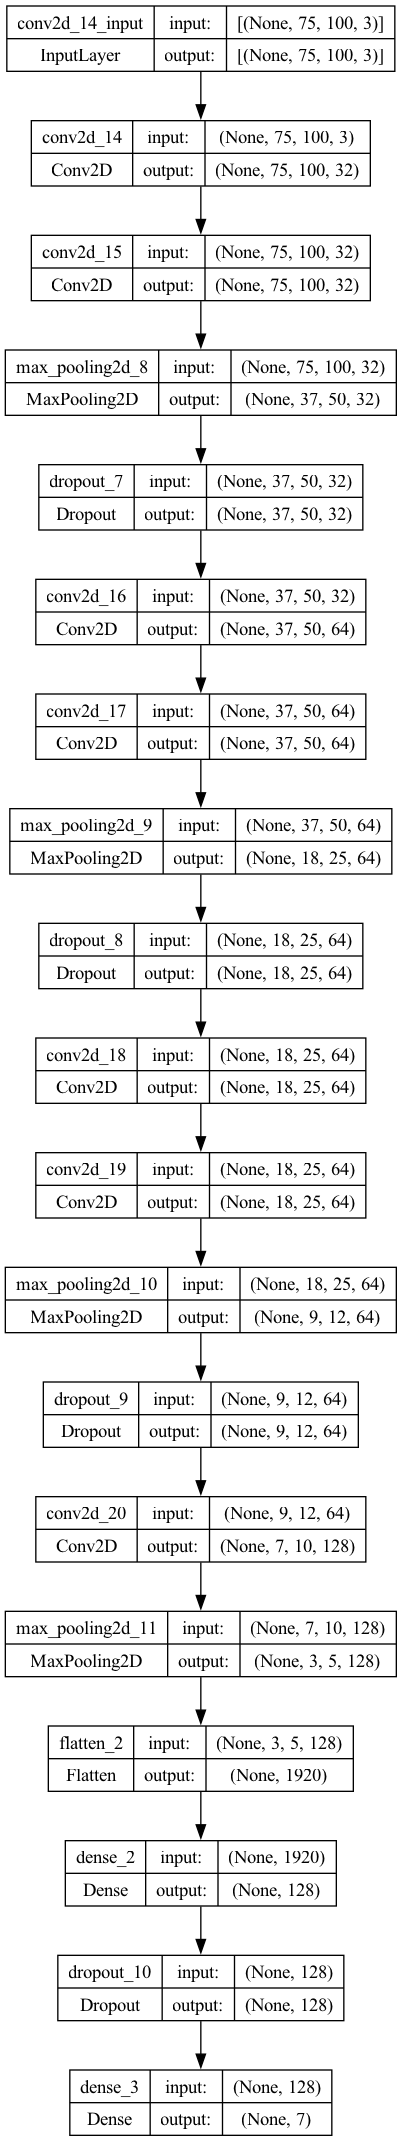

In [49]:
# Test the plot_model functionality
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [50]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

26/26 [==============================] - 4s 142ms/step - loss: 0.6853 - accuracy: 0.7556
Validation: accuracy = 0.755611  ;  loss_v = 0.685343
Test: accuracy = 0.742886  ;  loss = 0.711447


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [51]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1, len(model_history.history['accuracy']) // 10))
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1, len(model_history.history['loss']) // 10))
    axs[1].legend(['train', 'val'], loc='best')
    
    plt.show()

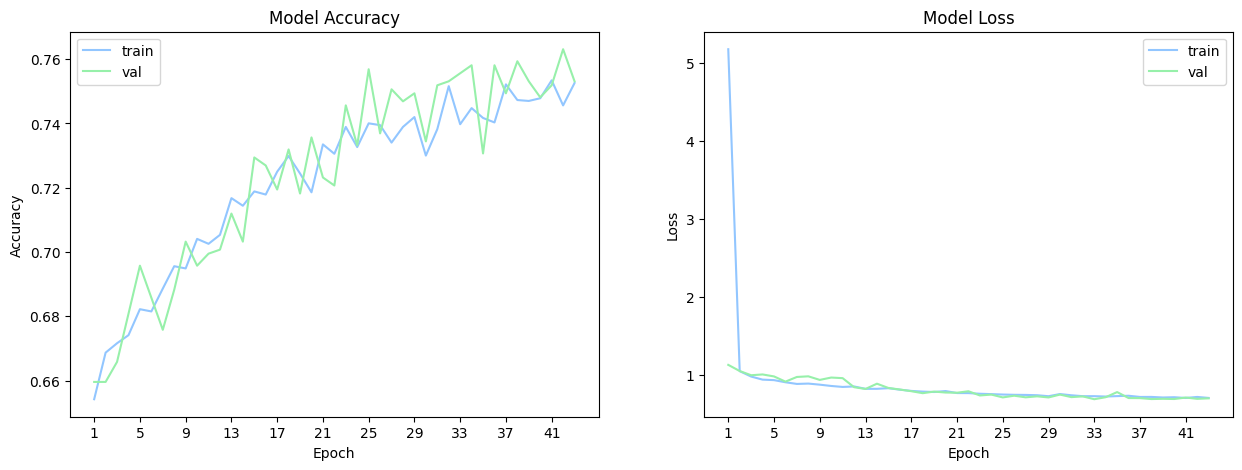

In [52]:
plot_model_history(history)

In [53]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

26/26 [==============================] - 3s 99ms/step


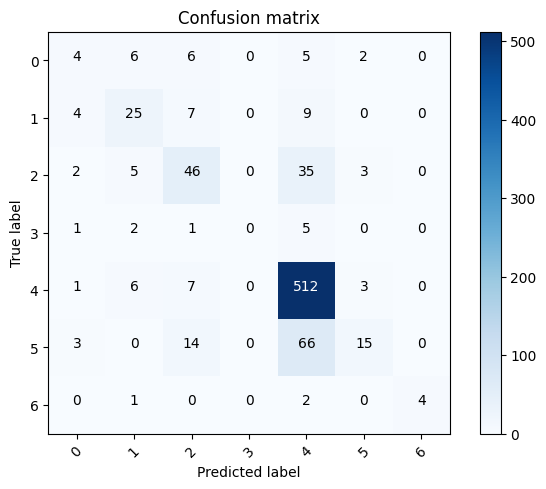

In [54]:
# Predict the values from the validation dataset
y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

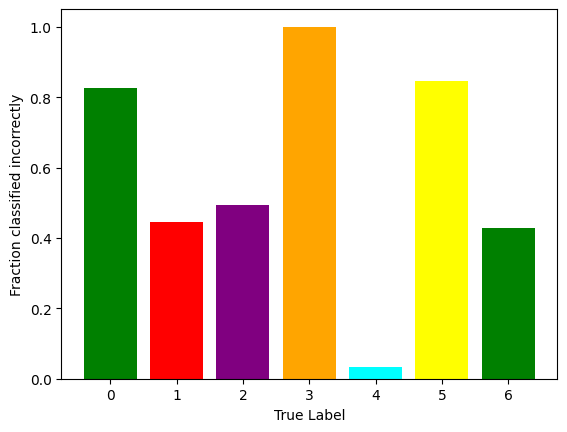

In [55]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error, color=colors)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')